# CNN Advanced Project

# PART 1

## Domain:
Entertainment

## Context:
Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis.
Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the
movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision
and multimedia experts who need to detect faces from screen shots from the movie scene.

## Data Description:
The dataset comprises of images and its mask where there is a human face.

## Project Objective:
Face detection from training images.

# Entertainment

## 1. Import the dataset.

**Loading the Dataset**

In [1]:
!pip install tensorflow==2.4.1
!pip install keras==2.0.0
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [2]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd "/content/drive/MyDrive/AIML"

/content/drive/MyDrive/AIML


**Importing the Libraries**

In [5]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

In [6]:
# Loading the images file

data = np.load('images.npy', allow_pickle=True)

In [7]:
data.shape

(409, 2)

The file contains 409 images and labels. Let's view few images and their labels.

In [8]:
data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [9]:
data[408][1]

[{'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.586206896551

**Viewing few random images and labels in the dataset**

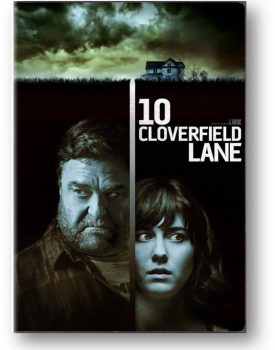

In [10]:
from google.colab.patches import cv2_imshow

cv2_imshow(data[23][0])

In [11]:
fi,ax = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## 2. Create features (images) and labels (mask) using that data.

**Creating features (images) and labels (mask)**

In [12]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  # assign all pixels in the first 3 channels only to the image, i.e., discard the alpha channel
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
    # convert the grayscale image to color so that the number of channels are standardized to 3
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    # set all pixels within the mask co-ordinates to 1.
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")


Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


**Splitting the data into train and test sets**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


**Visualizing X_train and y_train images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


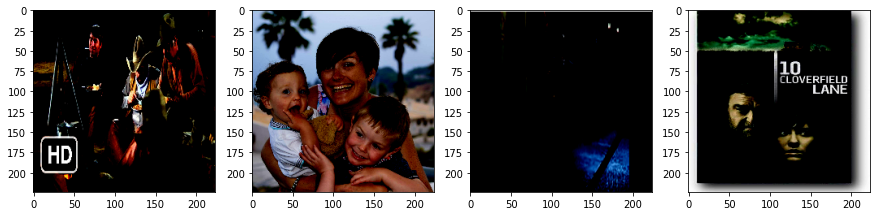

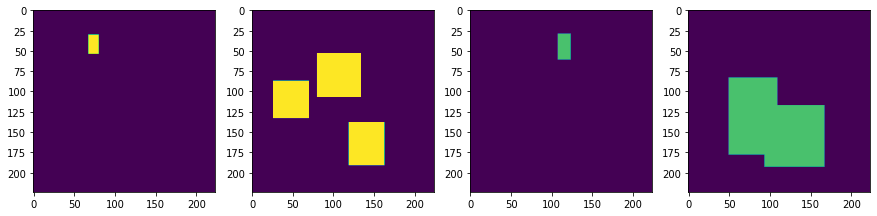

In [14]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

## 3. Mask detection model:

### Design a face mask detection model.
### Hint: Use U-net along with pre-trained transfer learning models

**Creating a Mask Detection Model using U-net with MobileNet Transfer Learning Model**

In [15]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

In [16]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [17]:
model = model()
model.summary()

2023424/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 16) 0           bn_Conv1[0][0]                   
_______________________________

### Design your own Dice Coefficient and Loss function.

**Designing Dice Coefficient and Loss function**

In [18]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

### Train, tune and test the model.

**Compliling the Model**

In [19]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [20]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

**Training the Model**

In [21]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 29s 143ms/step - loss: 0.7455 - dice_coef: 0.2545 - recall: 0.8609 - precision: 0.1642 - val_loss: 0.7770 - val_dice_coef: 0.2091 - val_recall: 1.0000 - val_precision: 0.1214
Epoch 2/30
41/41 [==============================] - 3s 79ms/step - loss: 0.6270 - dice_coef: 0.3730 - recall: 0.9271 - precision: 0.3434 - val_loss: 0.7528 - val_dice_coef: 0.2340 - val_recall: 0.9996 - val_precision: 0.1428
Epoch 3/30
41/41 [==============================] - 3s 79ms/step - loss: 0.6130 - dice_coef: 0.3870 - recall: 0.9340 - precision: 0.4183 - val_loss: 0.6994 - val_dice_coef: 0.2865 - val_recall: 0.9916 - val_precision: 0.2123
Epoch 4/30
41/41 [==============================] - 4s 86ms/step - loss: 0.6001 - dice_coef: 0.3999 - recall: 0.9347 - precision: 0.4431 - val_loss: 0.6398 - val_dice_coef: 0.3425 - val_recall: 0.9717 - val_precision: 0.3248
Epoch 5/30
41/41 [==============================] - 3s 82ms/step - loss: 0.5773 - dice_coef: 0.422

### Evaluate the model using testing data.

**Evaluating the Model**

In [22]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 1s 205ms/step - loss: 0.6531 - dice_coef: 0.3502 - recall: 0.6516 - precision: 0.4514


[0.6530978083610535,
 0.35016798973083496,
 0.6515606045722961,
 0.4514038562774658]

The model has precision and recall of 45.14% and 65.16% respectively. The loss is 65.31% and dice coefficient is 35.02%. 

## 4. Use the “Prediction image” as an input to your designed model and display the output of the image.

**Predicting an image that was not used for training and testing the model**

In [23]:
filename = './Part+1Test+Data+-+Prediction+Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [24]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [25]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.34192926],
         [0.23962256],
         [0.23865592],
         ...,
         [0.23755369],
         [0.2607083 ],
         [0.30862328]],

        [[0.27678585],
         [0.2006176 ],
         [0.18206337],
         ...,
         [0.20124882],
         [0.18724023],
         [0.23676232]],

        [[0.24586007],
         [0.17650516],
         [0.16886953],
         ...,
         [0.19231072],
         [0.1901799 ],
         [0.22336763]],

        ...,

        [[0.17417446],
         [0.14904857],
         [0.18845059],
         ...,
         [0.16210063],
         [0.14105877],
         [0.18454453]],

        [[0.19512343],
         [0.15662824],
         [0.19306721],
         ...,
         [0.15741241],
         [0.13993604],
         [0.18877865]],

        [[0.18640882],
         [0.19469967],
         [0.18639526],
         ...,
         [0.17403857],
         [0.1590453 ],
         [0.21256743]]]], dtype=float32)

In [26]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

**Viewing the predicted image and its face-detected output**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


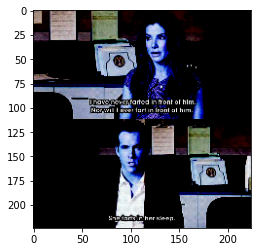

In [27]:
plt.imshow(feat_scaled)

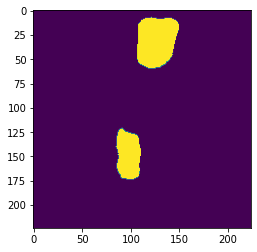

In [28]:
plt.imshow(pred_mask)

The model was able to detect two faces in the image correctly.

# PART 2

## Domain:
Face recognition

## Context:
Company X intends to build a face identi!ication model to recognise human faces.

## Data Description:
The dataset comprises of images and its mask where there is a human face.

## Project Objective:
Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken
from 'Pinterest' and aligned using dlib library. Some data samples:

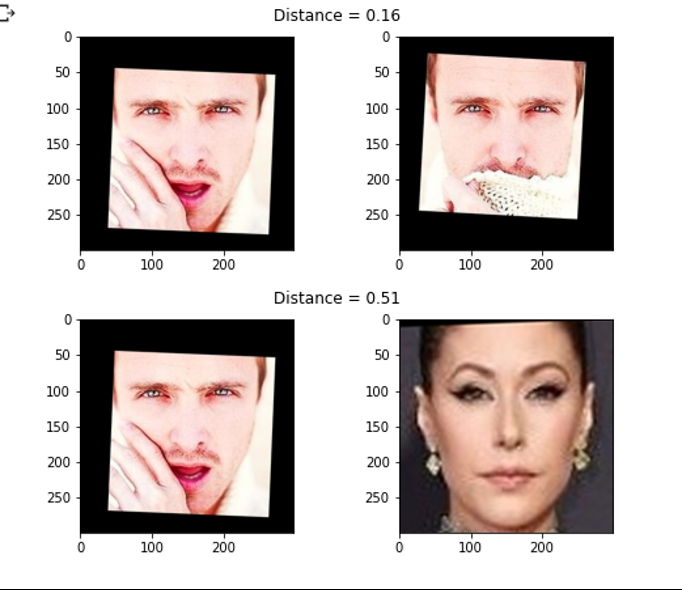

## Task: 
In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly
interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project.

## Load the dataset and create the metadata.

In [29]:
cd '/content/drive/MyDrive/AIML'

/content/drive/MyDrive/AIML


In [30]:
project_path = '/content/drive/MyDrive/AIML/'

**Unzipping the file**

In [31]:
from zipfile import ZipFile

# specifying the zip file name
file_name = project_path + "Aligned+Face+Dataset+from+Pinterest+-+CV+project+1.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    # zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!


In [32]:
directory = '/content/drive/MyDrive/AIML/pins/PINS/'

**Renaming the images and extracting only the person's name**

In [33]:
# Get the list of all files and directories
dir_list = os.listdir(directory)
 
print("Files and directories in '", directory, "' :")
 
# prints all files
print(dir_list)



Files and directories in ' /content/drive/MyDrive/AIML/pins/PINS/ ' :
['pins_Aaron Paul', 'pins_Alvaro Morte', 'pins_Amanda Crew', 'pins_Amaury Nolasco', 'pins_Anna Gunn', 'pins_Benedict Cumberbatch', 'pins_Betsy Brandt', 'pins_Brenton Thwaites', 'pins_Brit Marling', 'pins_Bryan Cranston', 'pins_Caity Lotz', 'pins_Cameron Monaghan', 'pins_Chance Perdomo', 'pins_Chris Evans', 'pins_Chris Pratt', 'pins_Cobie Smulders', 'pins_Danielle Panabaker', 'pins_Dave Franco', 'pins_Dominic Purcell', 'pins_Dwayne Johnson', 'pins_Emilia Clarke', 'pins_Emily Bett Rickards', 'pins_Emma Stone', 'pins_Gwyneth Paltrow', 'pins_Henry Cavil', 'pins_Jason Momoa', 'pins_Jeremy Renner', 'pins_Jesse Eisenberg', 'pins_Jim Parsons', 'pins_Jon Bernthal', 'pins_Josh Radnor', 'pins_Kit Harington', 'pins_Krysten Ritter', 'pins_Kumail Nanjiani', 'pins_Maisie Williams', 'pins_Mark Ruffalo', 'pins_Martin Starr', 'pins_Melissa benoit', 'pins_Mike Colter', 'pins_Morena Baccarin', 'pins_Morgan Freeman', 'pins_Natalie Portma

In [34]:
for filename in os.listdir(directory):
    str = "pins_"
    if str in filename:    
        filepath = os.path.join(directory, filename)
        newfilepath = os.path.join(directory, filename.replace(str, ""))
        os.rename(filepath, newfilepath)
        
for subdir, dirs, files in os.walk(directory):
    for file in files:
      os.rename(os.path.join(subdir, file), os.path.join(subdir, file.replace(' ', '_')))

for filename in os.listdir(directory):
    os.rename(os.path.join(directory,filename),os.path.join(directory, filename.replace(' ', '_').upper()))
  


**Displaying all the labels**

In [35]:
import glob

paths = glob.glob("pins/PINS/*")
label_names = [os.path.split(x)[1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format((label_names)))

Total labels: 100
Labels: ['AARON_PAUL', 'ALVARO_MORTE', 'AMANDA_CREW', 'AMAURY_NOLASCO', 'ANNA_GUNN', 'BENEDICT_CUMBERBATCH', 'BETSY_BRANDT', 'BRENTON_THWAITES', 'BRIT_MARLING', 'BRYAN_CRANSTON', 'CAITY_LOTZ', 'CAMERON_MONAGHAN', 'CHANCE_PERDOMO', 'CHRIS_EVANS', 'CHRIS_PRATT', 'COBIE_SMULDERS', 'DANIELLE_PANABAKER', 'DAVE_FRANCO', 'DOMINIC_PURCELL', 'DWAYNE_JOHNSON', 'EMILIA_CLARKE', 'EMILY_BETT_RICKARDS', 'EMMA_STONE', 'GWYNETH_PALTROW', 'HENRY_CAVIL', 'JASON_MOMOA', 'JEREMY_RENNER', 'JESSE_EISENBERG', 'JIM_PARSONS', 'JON_BERNTHAL', 'JOSH_RADNOR', 'KIT_HARINGTON', 'KRYSTEN_RITTER', 'KUMAIL_NANJIANI', 'MAISIE_WILLIAMS', 'MARK_RUFFALO', 'MARTIN_STARR', 'MELISSA_BENOIT', 'MIKE_COLTER', 'MORENA_BACCARIN', 'MORGAN_FREEMAN', 'NATALIE_PORTMAN_', 'NEIL_PATRICK_HARRIS', 'PAUL_RUDD', 'PEDRO_ALONSO', 'PETER_DINKLAGE', 'RJ_MITTE', 'RAMI_MELEK', 'ROBERT_KNEPPER', 'ROBIN_TAYLOR', 'RYAN_REYNOLDS', 'SARAH_WAYNE_CALLIES', 'SCARLETT_JOHANSSON', 'SEBASTIAN_STAN', 'SOPHIE_TURNER', 'STEPHEN_AMELL', 'SUND

## Check some samples of metadata.

**Saving the metadata in a dataframe**

In [36]:
df = pd.DataFrame(columns=['Person', 'No. of Images','File Path', 'Files'])

folders = [x[0] for x in os.walk(directory)]

for subfolders in folders:
  fileList = os.listdir(subfolders)
  filePath = os.path.abspath(subfolders)
  person = (subfolders)[len(directory):]
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)

df


,Person,No. of Images,File Path,Files
0,,100,/content/drive/MyDrive/AIML/pins/PINS,"[AARON_PAUL, ALVARO_MORTE, AMANDA_CREW, AMAURY..."
1,AARON_PAUL,86,/content/drive/MyDrive/AIML/pins/PINS/AARON_PAUL,"[Aaron_Paul0_262.jpg, Aaron_Paul101_247.jpg, A..."
2,ALVARO_MORTE,91,/content/drive/MyDrive/AIML/pins/PINS/ALVARO_M...,"[Alvaro_Morte100_825.jpg, Alvaro_Morte101_873...."
3,AMANDA_CREW,118,/content/drive/MyDrive/AIML/pins/PINS/AMANDA_CREW,"[Amanda_Crew0.jpg, Amanda_Crew1.jpg, Amanda_Cr..."
4,AMAURY_NOLASCO,113,/content/drive/MyDrive/AIML/pins/PINS/AMAURY_N...,"[Amaury_Nolasco0.jpg, Amaury_Nolasco1.jpg, Ama..."
...,...,...,...,...
96,SHAKIRA,50,/content/drive/MyDrive/AIML/pins/PINS/SHAKIRA,"[shakira0.jpg, shakira1.jpg, shakira10.jpg, sh..."
97,TATI_GABRIELLE,65,/content/drive/MyDrive/AIML/pins/PINS/TATI_GAB...,"[tati_gabrielle0.jpg, tati_gabrielle1.jpg, tat..."
98,TAYLOR_SWIFT,99,/content/drive/MyDrive/AIML/pins/PINS/TAYLOR_S...,"[taylor_swift0.jpg, taylor_swift1.jpg, taylor_..."
99,TOM_HOLLAND_FACE,119,/content/drive/MyDrive/AIML/pins/PINS/TOM_HOLL...,"[tom_holland_face0.jpg, tom_holland_face1.jpg,..."


**Visualizing few images from each label**

In [37]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, (300, 100))
grid = ImageGrid(fig, 111, nrows_ncols=(100, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob.glob(os.path.join("pins/PINS", label, "*.jpg"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Creating the features and target sets**

In [38]:
#save the path into variable to use it easily next times.
TRAIN_FOLDER= "pins/PINS"

In [39]:
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [40]:
len(images)

10770

**Performing preprocessing for all the images**

In [41]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [42]:
images[0].shape

(224, 224, 3)

**Displaying the shapes of images and classes**

In [43]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (10770, 224, 224, 3)
classes shape:  (10770,)


**Viewing the distribution of number of images in each class**

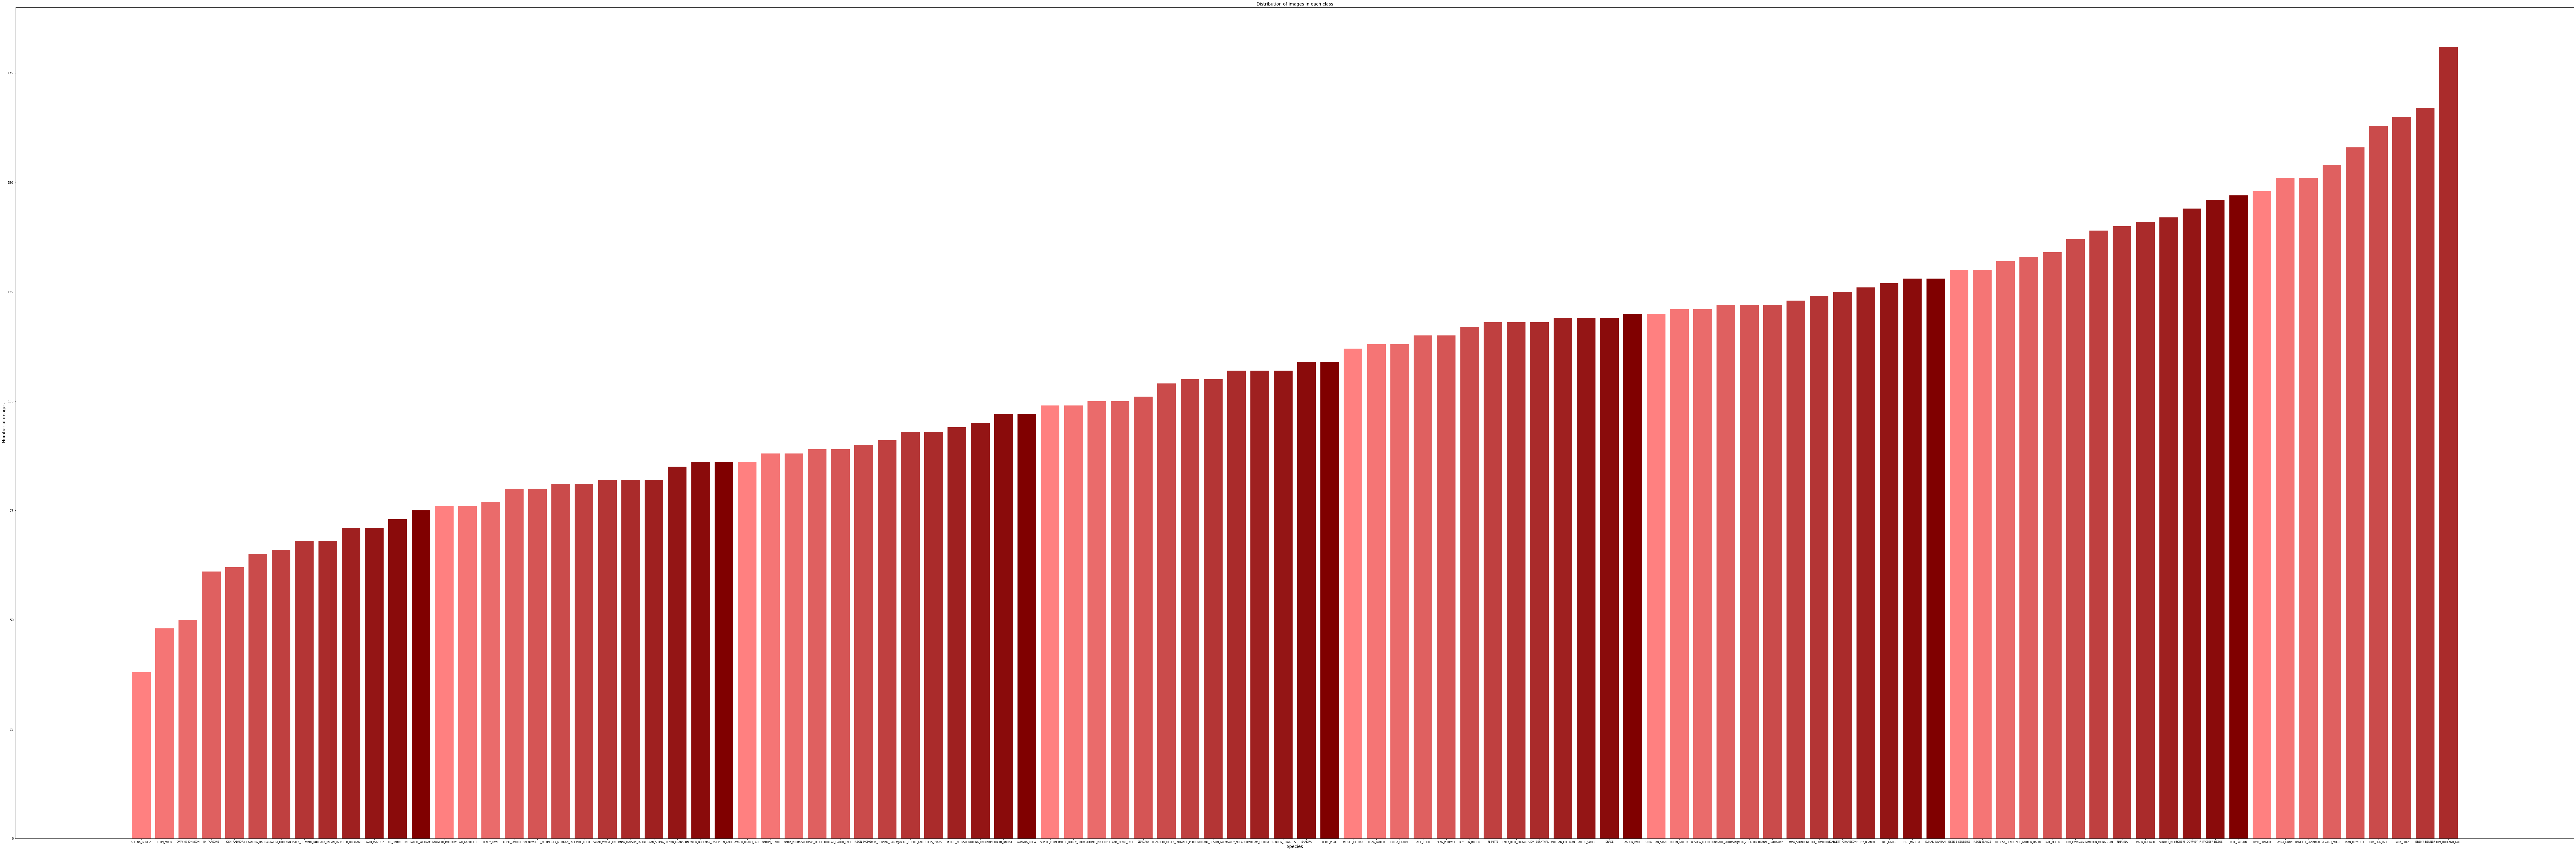

In [44]:
import matplotlib as mp

values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(150,50))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

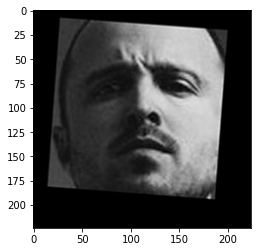

In [45]:
plt.imshow(images[50])

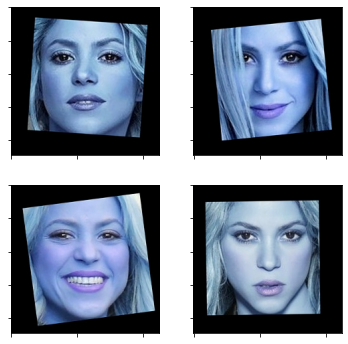

In [46]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes == label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("SHAKIRA")

The metadata for each image (file and identity name) are loaded into memory for later processing.

### Using class and method given in Questions_Face_Recognition by GL. Another method for storing the metadata.

In [47]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata(directory)

In [48]:
print('metadata shape :', metadata.shape)

metadata shape : (10770,)


In [49]:
metadata[1500]

/content/drive/MyDrive/AIML/pins/PINS/CHRIS_PRATT/Chris_Pratt95.jpg

In [50]:
type(metadata[1500]), metadata[1500].image_path()

(__main__.IdentityMetadata,
 '/content/drive/MyDrive/AIML/pins/PINS/CHRIS_PRATT/Chris_Pratt95.jpg')



## Load the pre-trained model and weights.



**Installing the keras-vggface package**

In [51]:
!pip install keras-vggface

In [52]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: h5py, pyyaml, six, numpy, pillow, scipy, keras
Required-by: 


In [53]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 5.9 MB/s 


In [54]:
# check version of keras_vggface
import keras_vggface
# print version
print(keras_vggface.__version__)

0.6


Using TensorFlow backend.


In [55]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [56]:
load_image("Benedict+Cumberbatch9.jpg")

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [57]:
load_image('./pins/PINS/CHRIS_EVANS/Chris_Evans13.jpg')

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[12, 11,  7],
        [12, 11,  7],
        [16, 12,  9],
        ...,
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 0,  0,  0]],

       [[ 6,  5,  1],
        [13, 12,  8],
        [22, 18, 15],
        ...,
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 0,  0,  0]],

       [[ 4,  0,  0],
        [15, 11,  8],
        [27, 23, 20],
        ...,
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

**Loading the pretrained vggface weights**

In [58]:
weights_file = project_path + 'vgg_face_weights.h5'

**Creating a VGG Face Model**

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [60]:
model = vgg_face()

model.load_weights(weights_file)

In [61]:
model.layers[0], model.layers[-2]

(<tensorflow.python.keras.layers.convolutional.ZeroPadding2D at 0x7f8bbf56ffd0>,
 <tensorflow.python.keras.layers.core.Flatten at 0x7f8bbf4f8fd0>)

In [62]:
# Remove last Softmax layer and get model upto last flatten layer #with outputs 2622 units 
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [63]:
type(vgg_face_descriptor)

tensorflow.python.keras.engine.functional.Functional

In [64]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>])

**Detecting Faces for Face Recognition**

In [65]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 15.4 MB/s 


In [66]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [67]:
cd '/content/drive/MyDrive/AIML'

/content/drive/MyDrive/AIML


**Viewing a sample image**

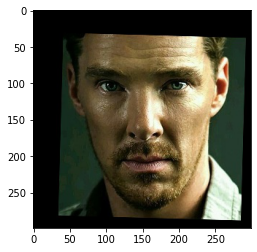

In [68]:
sample_pic = 'Benedict+Cumberbatch9.jpg'

# load image from file
image = plt.imread(sample_pic)
plt.imshow(image)

Next, initialize an MTCNN() object into the detector variable and use the .detect_faces() method to detect the faces in an image. Let’s see what it returns:

In [69]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [70]:
from mtcnn.mtcnn import MTCNN

# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(image)
for face in faces:
  print(face)


{'box': [60, 16, 179, 245], 'confidence': 0.999303936958313, 'keypoints': {'left_eye': (108, 103), 'right_eye': (194, 100), 'nose': (152, 160), 'mouth_left': (121, 208), 'mouth_right': (189, 205)}}


For every face, a Python dictionary is returned, which contains three keys. The box key contains the boundary of the face within the image. It has four values: x- and y- coordinates of the top left vertex, width, and height of the rectangle containing the face. The other keys are confidence and keypoints. The keypoints key contains a dictionary containing the features of a face that were detected, along with their coordinates:

**Highlighting Faces in an Image**

Now that we’ve successfully detected a face, let’s draw a rectangle over it to highlight the face within the image to verify if the detection was correct.

To draw a rectangle, import the Rectangle object from matplotlib.patches:

In [71]:
from matplotlib.patches import Rectangle

Let’s define a function highlight_faces to first display the image and then draw rectangles over faces that were detected. First, read the image through imread() and plot it through imshow(). For each face that was detected, draw a rectangle using the Rectangle() class.

Finally, display the image and the rectangles using the .show() method. If you’re using Jupyter notebooks, you may use the %matplotlib inline magic command to show plots inline:

In [72]:
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

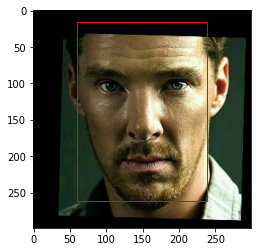

In [73]:
highlight_faces('Benedict+Cumberbatch9.jpg', faces)

Let’s display the second image and the face(s) detected in it:

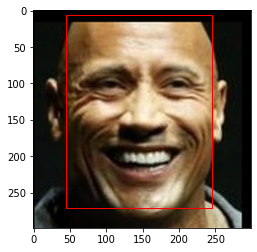

In [74]:
image = plt.imread('Dwayne+Johnson4.jpg')
faces = detector.detect_faces(image)

highlight_faces('Dwayne+Johnson4.jpg', faces)

In these two images, you can see that the MTCNN algorithm correctly detects faces. Let’s now extract this face from the image to perform further analysis on it.

**Extracting Face for Further Analysis**

At this point, you know the coordinates of the faces from the detector. Extracting the faces is a fairly easy task using list indices. However, the VGGFace2 algorithm that we use needs the faces to be resized to 224 x 224 pixels. We’ll use the PIL library to resize the images.

The function extract_face_from_image() extracts all faces from an image:

In [75]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = cv2.imread(filename)
 
	# create the detector, using default weights
	detector = MTCNN()
 
	# detect faces in the image
	results = detector.detect_faces(pixels)
 
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height

	# extract the face
	face = pixels[y1:y2, x1:x2]

	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

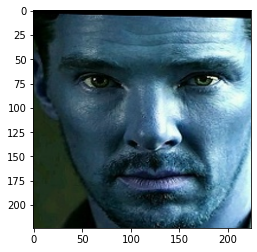

In [76]:
# load the photo and extract the face
pixels = extract_face('Benedict+Cumberbatch9.jpg')

# plot the extracted face
plt.imshow(pixels)

# show the plot
plt.show()

In [77]:
import keras
import keras.applications
from keras import applications
from keras.applications import vgg16

!pip install keras_vggface

In [78]:
!pip install keras_applications

**Performing image preprocessing before fed into the VGG Face model**

In [79]:
from numpy import expand_dims
from keras_vggface.utils import preprocess_input

# load the photo and extract the face
pixels = extract_face('Benedict+Cumberbatch9.jpg')

# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)

# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

**Predicting the label of the sample image**

In [80]:
from keras_vggface.utils import decode_predictions

# perform prediction
yhat = vgg_face_descriptor.predict(samples)

# convert prediction into names
results = decode_predictions(yhat)

# display most likely results
for result in results[0]:
	print('%s: %.2f%%' % (result[0], result[1]))

b'Joel_Edgerton': 10.76%
b'Will_Yun_Lee': 8.27%
b'Andrew_Scott': 8.26%
b'Michael_Bay': 7.90%
b'Nestor_Carbonell': 7.78%


The model was not able to predict the image correctly as Benedict Cumberbatch

## Generate Embedding vectors for each face in the dataset.

**Performing Face Verification With VGGFace2**

A VGGFace2 model can be used for face verification.

This involves calculating a face embedding for a new given face and comparing the embedding to the embedding for the single example of the face known to the system.

A face embedding is a vector that represents the features extracted from the face. This can then be compared with the vectors generated for other faces. For example, another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.

Typical measures such as Euclidean distance and Cosine distance are calculated between two embeddings and faces are said to match or verify if the distance is below a predefined threshold, often tuned for a specific dataset or application.

First, we can load the VGGFace model without the classifier by setting the ‘include_top‘ argument to ‘False‘, specifying the shape of the output via the ‘input_shape‘ and setting ‘pooling‘ to ‘avg‘ so that the filter maps at the output end of the model are reduced to a vector using global average pooling.

In [81]:
# Get embedding vector for first image in the metadata using the pre-trained model
from tensorflow.keras.models import Model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [82]:
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(0.031703066, numpy.ndarray, numpy.float32)

In [83]:
embedding_vector[2], embedding_vector[98], embedding_vector[-2]

(-0.012434022, -0.008693813, 0.002190807)

In [84]:
total_images = len(metadata)

print('total_images :', total_images)

total_images : 10770


In [85]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

In [86]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


In [87]:
embeddings[0], embeddings[988], embeddings[988].shape

(array([ 0.03170307, -0.0150513 , -0.01243402, ...,  0.00043141,
         0.00219081, -0.00908097]),
 array([-0.00044259,  0.01826   ,  0.01218895, ..., -0.03309939,
         0.0113669 ,  0.02154321]),
 (2622,))

In [88]:
embeddings[8275]

array([ 0.01786545,  0.00912621,  0.00244408, ..., -0.02196857,
        0.01290167,  0.04220533])

In [89]:
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)

	# perform prediction
	yhat = vgg_face_descriptor.predict(samples)
	return yhat

We can take our photograph of Benedict Cumberbatch used previously (e.g. Part 2- Test Image - Benedict Cumberbatch9.jpg) as our definition of the identity of Benedict Cumberbatch by calculating and storing the face embedding for the face in that photograph.

We can then calculate embeddings for faces in other photographs of Benedict Cumberbatch and test whether we can effectively verify his identity. We can also use faces from photographs of other people to confirm that they are not verified as Benedict Cumberbatch.

Verification can be performed by calculating the Cosine distance between the embedding for the known identity and the embeddings of candidate faces. This can be achieved using the cosine() SciPy function. The maximum distance between two embeddings is a score of 1.0, whereas the minimum distance is 0.0. A common cut-off value used for face identity is between 0.4 and 0.6, such as 0.5, although this should be tuned for an application.

The is_match() function below implements this, calculating the distance between two embeddings and interpreting the result.

**Defining functions to measure the distance between two different images to find how identical they are**

In [90]:
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [91]:
from scipy.spatial.distance import cosine

# define filenames
filenames = ['Benedict+Cumberbatch9.jpg','./pins/PINS/BENEDICT_CUMBERBATCH/Benedict_Cumberbatch31.jpg','./pins/PINS/BENEDICT_CUMBERBATCH/Benedict_Cumberbatch4.jpg','Dwayne+Johnson4.jpg']
# get embeddings file filenames
embeddings1 = get_embeddings(filenames)
# define benedict
benedict_id = embeddings1[0]
# verify known photos of benedict
print('Positive Tests')
is_match(embeddings1[0], embeddings1[1])
is_match(embeddings1[0], embeddings1[2])
# verify known photos of other people
print('Negative Tests')
is_match(embeddings1[0], embeddings1[3])

Positive Tests
>face is a Match (0.226 <= 0.500)
>face is a Match (0.245 <= 0.500)
Negative Tests
>face is NOT a Match (0.514 > 0.500)


## Build distance metrics for identifying the distance between two given images.

In [92]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

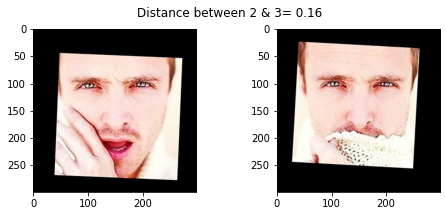

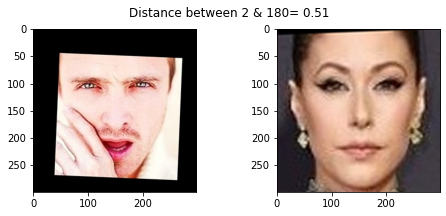

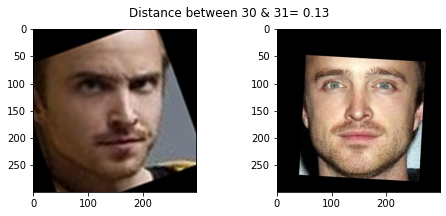

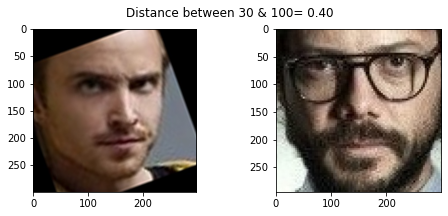

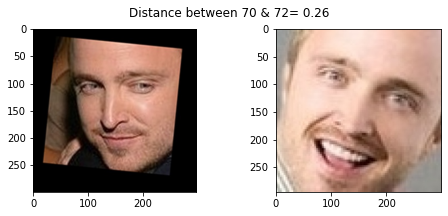

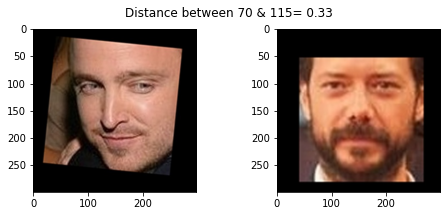

In [93]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

In [94]:
def L2Norm(H1,H2):
    distance =0
    for i in range(len(H1)):
        distance += np.square(H1[i]-H2[i])
    return np.sqrt(distance)

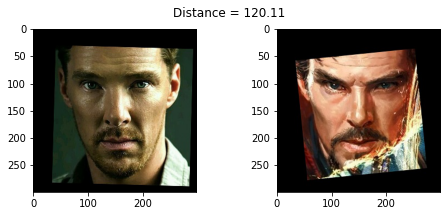

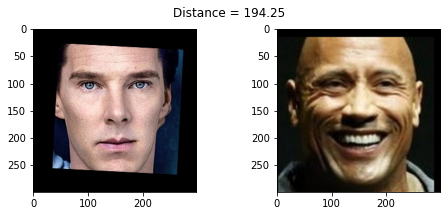

In [95]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {L2Norm(embeddings1[idx1], embeddings1[idx2]):.2f}')
    plt.subplot(121)
    img_1 = plt.imread(filenames[idx1])
    plt.imshow(img_1)
    plt.subplot(122)
    img_2 = plt.imread(filenames[idx2])
    plt.imshow(img_2)    

show_pair(0, 2)
show_pair(1, 3)

**Create train and test sets**
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [96]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [97]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [98]:
y_test[0], y_train[988]

('AARON_PAUL', 'CAMERON_MONAGHAN')

In [99]:
len(np.unique(y_test)), len(np.unique(y_train))

(100, 100)

**Encode the labels**
- Encode the targets
- Use LabelEncoder

In [100]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [101]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

['AARON_PAUL' 'ALEXANDRA_DADDARIO' 'ALVARO_MORTE'
 'ALYCIA_DEBNAM_CAREY_FACE' 'AMANDA_CREW' 'AMAURY_NOLASCO'
 'AMBER_HEARD_FACE' 'ANNA_GUNN' 'ANNE_HATHAWAY' 'BARBARA_PALVIN_FACE'
 'BELLAMY_BLAKE_FACE' 'BENEDICT_CUMBERBATCH' 'BETSY_BRANDT' 'BILL_GATES'
 'BRENTON_THWAITES' 'BRIE_LARSON' 'BRIT_MARLING' 'BRYAN_CRANSTON'
 'CAITY_LOTZ' 'CAMERON_MONAGHAN' 'CHADWICK_BOSEMAN_FACE' 'CHANCE_PERDOMO'
 'CHRIS_EVANS' 'CHRIS_PRATT' 'COBIE_SMULDERS' 'DANIELLE_PANABAKER'
 'DAVE_FRANCO' 'DAVID_MAZOUZ' 'DOMINIC_PURCELL' 'DRAKE' 'DUA_LIPA_FACE'
 'DWAYNE_JOHNSON' 'ELIZABETH_OLSEN_FACE' 'ELIZA_TAYLOR' 'ELON_MUSK'
 'EMILIA_CLARKE' 'EMILY_BETT_RICKARDS' 'EMMA_STONE' 'EMMA_WATSON_FACE'
 'GAL_GADOT_FACE' 'GRANT_GUSTIN_FACE' 'GWYNETH_PALTROW' 'HENRY_CAVIL'
 'JASON_ISAACS' 'JASON_MOMOA' 'JEFF_BEZOS' 'JEREMY_RENNER'
 'JESSE_EISENBERG' 'JIM_PARSONS' 'JON_BERNTHAL' 'JOSH_RADNOR'
 'KIERNAN_SHIPKA_' 'KIT_HARINGTON' 'KRISTEN_STEWART_FACE' 'KRYSTEN_RITTER'
 'KUMAIL_NANJIANI' 'LINDSEY_MORGAN_FACE' 'MAISIE_WILLIAMS'
 'MAR

In [102]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [ 0  0  0 ... 99 99 99]
y_test_encoded :  [ 0  0  0 ... 99 99 99]


**Encoding the labels for classes**

In [103]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y = enc.fit_transform(classes)

num_classes = len(np.unique(y))
num_classes

100

**Standardize the feature values**
- Scale the features using StandardScaler

In [104]:
# Standarize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [105]:
X_test_std = scaler.transform(X_test)

**Splitting data into training and testing set for images**



training set : 70%

testing set: 30%

In [106]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(images, y, test_size=0.3, random_state=50)

**Creating validation set**

splitting test and validation sets each with 50% of data

In [107]:
random_seed = 2
X_test1, X_val1, y_test1, y_val1 = train_test_split(X_test1,y_test1, test_size = 0.5, random_state=random_seed)

In [108]:
print(f"#### Shapes of Train, Test and Validation sets are: {X_train1.shape},{X_test1.shape},{X_val1.shape}")

#### Shapes of Train, Test and Validation sets are: (7539, 224, 224, 3),(1615, 224, 224, 3),(1616, 224, 224, 3)


In [109]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train1.shape},{y_test1.shape},{y_val1.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (7539,),(1615,),(1616,)


## Use PCA for dimensionality reduction.

**Reduce dimensions using PCA**
- Reduce feature dimensions using Principal Component Analysis
- Set the parameter n_components=128

In [110]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))

X_train_std shape : (9573,2622)
y_train_encoded shape : (9573,)
X_test_std shape : (1197,2622)
y_test_encoded shape : (1197,)


In [111]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

### *Classification using Supervised Learning Techniques*

1. **Support Vector Machines**

The dataset have over 65536 features for each image and only 3336 images total in train dataset. To use an SVM, our model of choice, the number of features needs to be reduced.

PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components.

In [112]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [113]:
X_train_r, X_train_g, X_train_b = flatten(X_train1)
X_test_r, X_test_g, X_test_b = flatten(X_test1)
X_val_r, X_val_g, X_val_b = flatten(X_val1)

In [114]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((1616, 50176), (1616, 50176), (1616, 50176))

In [115]:
from sklearn.decomposition import PCA as RandomizedPCA

n_components = 500
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [116]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [117]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.9668704137426661, 0.9680102266596676, 0.9722770055040614)

In [118]:
X_train_pca1 = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca1 = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca1 = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [119]:
X_train_pca1.shape, y_train1.shape,
X_test_pca1.shape, y_test1.shape,
X_val_pca1.shape, y_val1.shape

((1616, 1500), (1616,))

## Build an SVM classifier in order to map each image to its right person.

**Build a Classifier**
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [120]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [121]:
y_predict = clf.predict(X_test_pca)

In [122]:
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)

y_predict :  [ 0  0  0 ... 99 99 99]
y_test_encoded :  [ 0  0  0 ... 99 99 99]


In [123]:
y_predict_encoded = le.inverse_transform(y_predict)

In [124]:
print('y_predict_encoded : ',y_predict_encoded)

y_predict_encoded :  ['AARON_PAUL' 'AARON_PAUL' 'AARON_PAUL' ... 'ZENDAYA' 'ZENDAYA' 'ZENDAYA']


In [125]:
print('y_predict shape : ', y_predict.shape)
print('y_test_encoded shape : ', y_test_encoded.shape)

y_predict shape :  (1197,)
y_test_encoded shape :  (1197,)


In [126]:
y_test_encoded[32:49]

array([4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7])

In [127]:
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
# Find the classification accuracy
accuracy_score(y_test_encoded, y_predict)

0.9507101086048454

**Accuracy Score: 95.071%**

**Using another method**

In [128]:
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca1, y_train1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [129]:
X_train1.shape[0]

7539

In [130]:
y_train1.shape[0]

7539

In [131]:
svm_score = clf.score(X_val_pca1, y_val1)

In [132]:
from sklearn import svm, metrics

y_pred = clf.predict(X_test_pca1)
svm_accuracy = metrics.accuracy_score(y_test1, y_pred)

## Import the the test image. Display the image. Use the SVM trained model to predict the face.

**Test results**
- Take 10th image from test set and plot the image
- Report to which person(folder name in dataset) the image belongs to

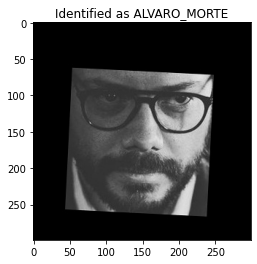

In [133]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

In [134]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Predicted Person'])

model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': accuracy_score(y_test_encoded, y_predict),
                                              'Predicted Person': example_identity                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Predicted Person
0,SVM,0.95071,ALVARO_MORTE


**Prediction using SVM**

In [135]:
image = 'Dwayne+Johnson4.jpg'
img_pred = plt.imread(image)
img_pred_resize = cv2.resize(img_pred,(224,224), interpolation = cv2.INTER_CUBIC)
img_predict = np.expand_dims(img_pred_resize, axis=0)

pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [136]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca2 = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [137]:
pred_svm = clf.predict(X_pred_pca2)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'31'


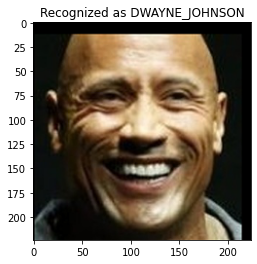

In [138]:
example_identity = enc.inverse_transform(np.ravel(pred_svm))[0]

plt.imshow(img_pred_resize)
plt.title(f'Recognized as {example_identity}');

In [139]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Predicted Person': example_identity                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Predicted Person
0,SVM,0.950710,ALVARO_MORTE
1,SVM,0.013622,DWAYNE_JOHNSON


In [140]:
image = 'Benedict+Cumberbatch9.jpg'
img_pred = plt.imread(image)
img_pred_resize = cv2.resize(img_pred,(224,224), interpolation = cv2.INTER_CUBIC)
img_predict = np.expand_dims(img_pred_resize, axis=0)

pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [141]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca3 = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [142]:
pred_svm = clf.predict(X_pred_pca3)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'11'


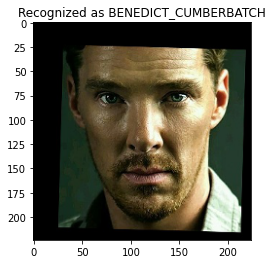

In [143]:
example_identity = enc.inverse_transform(np.ravel(pred_svm))[0]

plt.imshow(img_pred_resize)
plt.title(f'Recognized as {example_identity}');

In [144]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Predicted Person': example_identity                                      
                                              }, ignore_index=True)
model_performance

,Model,Accuracy,Predicted Person
0,SVM,0.950710,ALVARO_MORTE
1,SVM,0.013622,DWAYNE_JOHNSON
2,SVM,0.013622,BENEDICT_CUMBERBATCH
